# Latin Hypercube Sampling 
This notebooks walks through [Latin Hypercube Sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) (LHS) and explains how it differs from the standard [Gaussian Random Sampling](https://en.wikipedia.org/wiki/Normal_distribution) implemented in LIME.

Standard Gaussian random sampling draws samples from a standard normal distribution Probability Density Function (PDF), $\mathcal{N}(0,1)$. In practice, if we sample from $\mathcal{N}(0,1)$ many times, we will begin to obtain enough samples to "understand" the space from which we are sampling.

Some black-box models are computationally expensive, and in high dimensions, we require more samples from the standard normal distribution. We thus introduce a quasi-random process to reduce the needed number of sampled points while not losing our "understanding" of the space. LHS is a quasi-random process. LHS samples from a n-dimensional CDF (a n-dimensional hypercube) and places points spread out in the space. It is somewhat analogous to the problem of placing non-attacking rooks on a chessboard. The points are placed to sample all of the features in such a way that the points are distributed across the CDF. We then use a point percentile function (PPF) to go from the CDF to the PDF so we can do the same computations LIME does to the Gaussian points. 

This notebook walks through some examples of both sampling methods and shows how using LHS can save one run time.

In [1]:
# imports 
from lime import lime_tabular
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
from pyDOE2 import lhs
from scipy.stats.distributions import norm

np.random.seed(1) # for repeatability 

### Visualizing the differnce between Gaussian sampling and LHS

Let us consider a toy problem with $n=2$ features (for the ease of visualizing). We can compare what the sampled points for Gaussian sampling and LHS will look like. We compare these plots for $s = 25$ samples (to build intuition).

In [2]:
n = 2                                                      # number of features
s = 25                                                     # number of samples

gauss_data = np.random.normal(0,1,n*s).reshape(s,n)        # how lime generates the values
lhs_data = lhs(n,s)                                        # lhs generated data

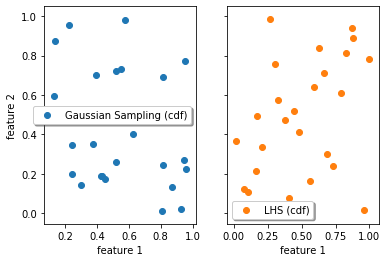

In [3]:
# visualizing the results in the cdf
means = np.zeros(n)
stdvs = np.array([1]*n)
gaus_cdf = np.zeros((s,n))
for i in range(n):
    gaus_cdf[:,i] = norm(loc=means[i], scale=stdvs[i]).cdf(gauss_data[:,i])
    
    
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)

ax1.scatter(gaus_cdf[:,0],gaus_cdf[:,1],color='tab:blue',label='Gaussian Sampling (cdf)')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
ax1.legend(shadow=True,fancybox=True)

ax2.scatter(lhs_data[:,0], lhs_data[:,1],color='tab:orange',label='LHS (cdf)')
ax2.set_xlabel('feature 1')
ax2.legend(shadow=True, fancybox=True)

plt.show()

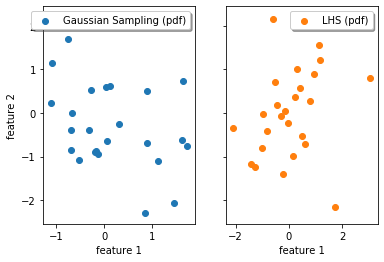

In [4]:
# visualizing the the distribution of points in the pdf
# transformation lhs from cdf to pdf
means = np.zeros(n)
stdvs = np.array([1]*n)
for i in range(n):
    lhs_data[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(lhs_data[:, i])   

fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)

ax1.scatter(gauss_data[:,0],gauss_data[:,1],color='tab:blue',label='Gaussian Sampling (pdf)')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
ax1.legend(shadow=True,fancybox=True)

ax2.scatter(lhs_data[:,0], lhs_data[:,1],color='tab:orange',label='LHS (pdf)')
ax2.set_xlabel('feature 1')
ax2.legend(shadow=True, fancybox=True)

plt.show()

Intuitively, it appears that the LHS method, since the points are better distributed through the space, would require fewer points to be generated. In both the CDF and PDF, we see LHS spreads out over the space more than the Gaussian sampling approach. 

Let us test this on the [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset. 

In [5]:
# imports for the iris data set and model
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
# train a black box model on the data set
np.random.seed(1)
iris = load_iris()
train, test, labels_train, labels_test = train_test_split(iris.data, iris.target, train_size=0.80)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(11,6), random_state=1)
clf.fit(train, labels_train)
print('model accuracy score: ',accuracy_score(labels_test, clf.predict(test)))

# point to explain
test_instance = test[8]

model accuracy score:  0.9333333333333333


Now that we have a pretty good black-box model, let's compare the top weight (as predicted by LIME). First, we will do it for just one run and fix the number of samples at $s = 5000$, which is the default number of samples.

In [7]:
# gaussian sampling for LIME
explainer = lime_tabular.LimeTabularExplainer(train,10,feature_names=iris.feature_names,class_names=iris.target_names,discretize_continuous=False)
exp = explainer.explain_instance(test_instance,clf.predict_proba,num_features=1,top_labels=1,num_samples=5000,model_regressor=None,sampling_method='gauss')
exp.show_in_notebook()

In [8]:
# LHS sampling for LIME
explainer = lime_tabular.LimeTabularExplainer(train,10,feature_names=iris.feature_names,class_names=iris.target_names,discretize_continuous=False)
exp = explainer.explain_instance(test_instance,clf.predict_proba,num_features=1,top_labels=1,num_samples=5000,model_regressor=None,sampling_method='lhs')
exp.show_in_notebook()

Notice that in both cases, we obtain the same explanation! Now we can test this and see what happens when we change the number of samples. 

In [9]:
max_samples = 5000

samp = []
weight_gauss = []
weight_lhs = []

for i in range(10,max_samples+1):
    
    # gaussian random sampling explanation
    explainer_gauss = lime_tabular.LimeTabularExplainer(train,i,feature_names=iris.feature_names,class_names=iris.target_names,discretize_continuous=False)
    exp_gauss = explainer.explain_instance(test_instance,clf.predict_proba,num_features=1,top_labels=1,num_samples=i,model_regressor=None,sampling_method='gauss')
    _gauss = list(exp_gauss.local_exp.values())[0][0][1]
    
    # lhs random sampling explanation
    explainer_lhs = lime_tabular.LimeTabularExplainer(train,i,feature_names=iris.feature_names,class_names=iris.target_names,discretize_continuous=False)
    exp_lhs = explainer.explain_instance(test_instance,clf.predict_proba,num_features=1,top_labels=1,num_samples=i,model_regressor=None,sampling_method='lhs')
    _lhs = list(exp_lhs.local_exp.values())[0][0][1]
    
    # appending the data
    samp.append(i)
    weight_gauss.append(_gauss)
    weight_lhs.append(_lhs) 

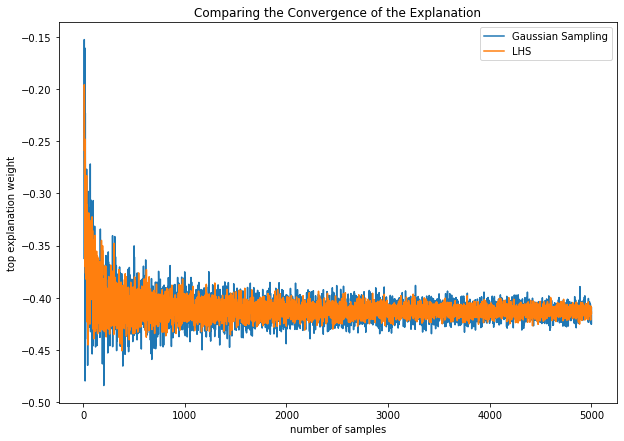

In [10]:
# plotting the data generated in the previous step
plt.figure(1,[10,7])
plt.plot(samp,weight_gauss,color='tab:blue',label='Gaussian Sampling')
plt.plot(samp,weight_lhs,color='tab:orange',label='LHS')
plt.xlabel('number of samples')
plt.ylabel('top explanation weight')
plt.title('Comparing the Convergence of the Explanation')
plt.legend()
plt.show()

We can see that both sampling methods converge to the same top weight. These results extend to all other weights as well, as LHS does not introduce bias. 

For LHS, we have consistently less varied results and faster convergence. Utilizing LHS, one could reduce the number of samples to increase the speed of explanations without losing any information or reliability. 